<hr>
<br><br><br>
<div align=center>
<font size=2>
        Trabalho de Conclusão de Curso
    </font>
    <br><br><BR>
    <font size=3>
        Classificação de sentimento em arquivos de áudio<br>a partir da extração de Coeficientes Cepstrais na frequência Mel<br>(MFCCs)
    </font>
    <br><br><BR>
    <font size=2>
        ICMC-USP
    </font>    
</div>
<br><br><br>
<hr>

<br><br>
<a id=menu></a>

[Biblotecas](#libs) <br>
[Dados](#data) <br>
[Pré-processamento](#prep) <br>
[Processamento](#proc) <br>
[Avaliação](#aval) <br>

<br>

<a id='libs'></a>
<h3>Bibliotecas</h3>
<br>
<blockquote>
    <dl>
        <dl>- keras: interface para desenvolvimento de redes neurais.</dl>
        <dl>- librosa: múltiplas funcionalidades para tratamento de arquivos de áudio.</dl>
        <dl>- Matplotlib: criação de gráficos e visuadlzação de dados.</dl>
        <dl>- Numpy: processamento de vetores e matrizes multimensionais.</dl>
        <dl>- Pandas: manipulação e análise de dados tabulares e séries temporais</dl>
        <dl>- Seaborn: criação de gráficos e visualização de dados.</dl>
        <dl>- Sklearn: algoritmos de aprendizado de máquina.</dl>
        <dl>- TensorFlow: desenho de fluxos e processamento de tensores para aprendizado de máquina.</dl>
    </dl>
</blockquote>


In [1]:
import librosa as ls
import numpy as np 
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt 
import seaborn as sns

import os
from tqdm import tqdm 


<br>
<a id='data'></a>
<h3>Dados</h3>

<font size=1>[menu](#menu)</font>

In [2]:
# Getting file paths
files_list = []
for dirname, _, filenames in os.walk('../data/archive'):
    for filename in filenames:
        files_list.append(os.path.join(dirname, filename))

print(f'Total files: {len(files_list)}')

Total files: 1441


In [3]:
### Search just for wav files
files_list = [file for file in files_list if  '.wav' in file or '.mp3' in file]

In [4]:
emotions_dict = {'01' : 'neutral', 
                '02' : 'calm' ,
                '03' : 'happy' ,
                '04' : 'sad' ,
                '05' : 'angry', 
                '06' : 'fearful' ,
                '07' : 'disgust', 
                '08' : 'surprised'}

100%|██████████| 16/16 [00:40<00:00,  2.52s/it]


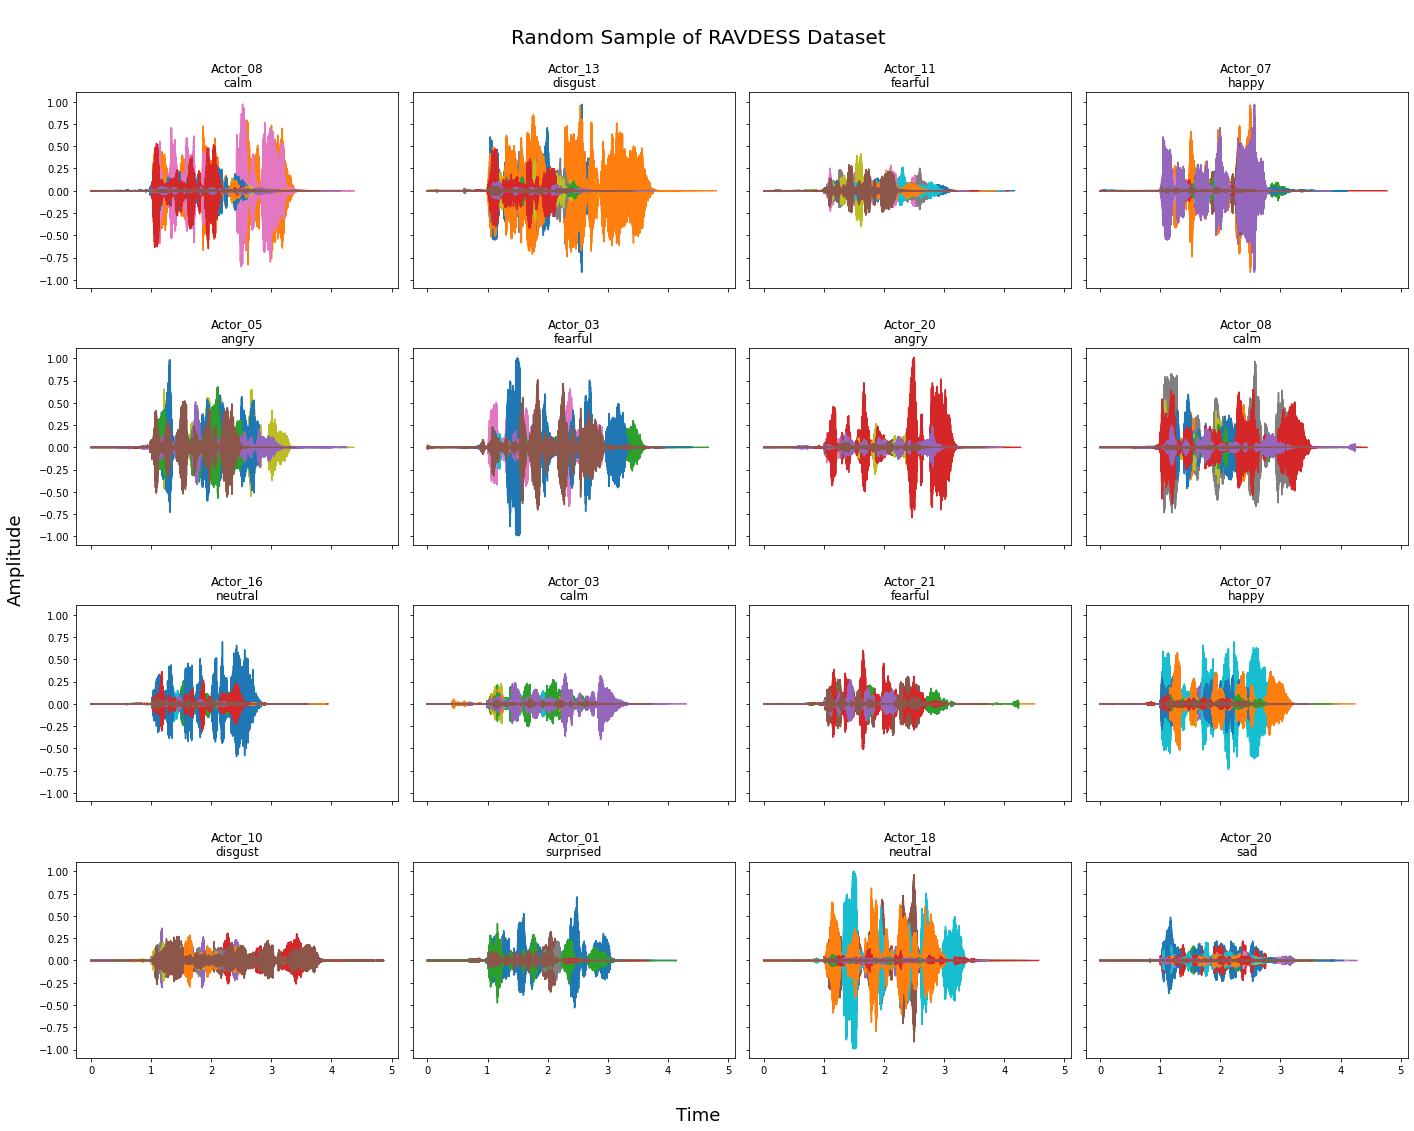

In [5]:
# Visualize random sample of data

rows = 4
columns = 4

fig, ax = plt.subplots(nrows=rows, ncols=columns, sharex=True, sharey=True, figsize=(rows*5,rows*4))

for i in tqdm(range(rows*columns)):
    for row in ax:
        for col in row:
            random_file_idx = np.random.randint(0, len(files_list))
            audio,sfreq = ls.load(files_list[random_file_idx])
            time = np.arange(0,len(audio))/sfreq
            col.plot(time,audio)
            col.set_title(f'\n{files_list[random_file_idx].split("/")[-2]}\n{emotions_dict[files_list[random_file_idx].split("-")[2]]}')
            # col.set_xlabel('Time')
            # col.set_ylabel('Amplitude')

fig.suptitle('\nRandom Sample of RAVDESS Dataset', fontsize=20)
fig.supxlabel('\nTime', fontsize=18)
fig.supylabel('Amplitude\n', fontsize=18)
fig.tight_layout()

<br>
<a id='prep'></a>
<h3>Pré-processamento</h3>

<font size=1>[menu](#menu)</font>

In [6]:
def extract_feature(file_name, mfcc, chroma, mel):
        X,sample_rate = ls.load(file_name)
        if chroma:
            stft=np.abs(ls.stft(X))
            result=np.array([])
        if mfcc:
            mfccs=np.mean(ls.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(ls.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(ls.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        return result

In [7]:
### Extract features from files
### and get associated emotion

features, emotions = [],[]
extract_log = {}

for file in tqdm(files_list):
        feature = extract_feature(file, mfcc=True, chroma=True, mel=True)
        emotion = emotions_dict[file.split("-")[2]]

        features.append(feature)
        emotions.append(emotion)

        actor = file.split('/')[-2]
        extract_log[actor] = emotion


100%|██████████| 1440/1440 [04:03<00:00,  5.91it/s]


In [8]:
### Encode emotions

lb = LabelEncoder()
Y = lb.fit_transform(emotions)
Y = to_categorical(Y)

print(Y.shape)
print(Y[0])

(1440, 8)
[1. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
### Normalize features 

scaler  =  MinMaxScaler()
X = scaler.fit_transform(features)

<br>
<a id='proc'></a>
<h3>Processamento</h3>

<font size=1>[menu](#menu)</font>

In [10]:
X_train, x_test, Y_train, y_test = train_test_split(X, Y,
                                                test_size=0.3,
                                                random_state=42,
                                                shuffle=True)

In [11]:
X = np.expand_dims(X, axis=2)

In [12]:
model = Sequential()
model.add(Dense(256, input_shape=(X.shape[-1],180)))
model.add(Dense(512))
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Dense(256))
model.add(Flatten())
model.add(Dense(8,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 256)            46336     
_________________________________________________________________
dense_1 (Dense)              (None, 1, 512)            131584    
_________________________________________________________________
dropout (Dropout)            (None, 1, 512)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1, 512)            262656    
_________________________________________________________________
dense_3 (Dense)              (None, 1, 256)            131328    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2

In [13]:
evaluate_metrics = ['categorical_accuracy','Precision','Recall','AUC','TruePositives','FalsePositives','MeanAbsoluteError','MeanSquaredError',]

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=evaluate_metrics)

In [14]:
model.fit(X_train, Y_train,
          batch_size = 128,
          epochs=200,
          validation_data=(x_test, y_test),
          verbose=0);

In [15]:
### Get loss progress
loss_per_epoch = model.history.history['loss']

In [16]:
score = model.evaluate(x_test, y_test);

14/14 [==============================] - 0s 2ms/step - loss: 2.3561 - categorical_accuracy: 0.5139 - precision: 0.5576 - recall: 0.4144 - auc: 0.8467 - true_positives: 179.0000 - false_positives: 142.0000 - mean_absolute_error: 0.1412 - mean_squared_error: 0.0865


In [17]:
### Save model

# model.save('Speech-Emotion-Recognition.h5')

<br>
<a id='aval'></a>
<h3>Avaliação</h3>

<font size=1>[menu](#menu)</font>

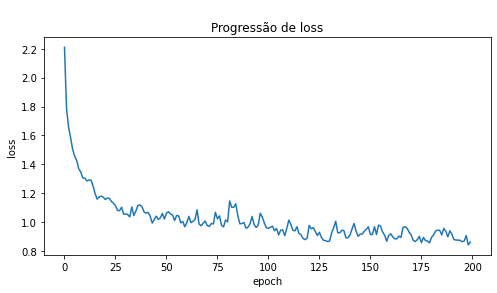

In [20]:
plt.figure(figsize=(8,4))
sns.lineplot(data=loss_per_epoch)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('\nProgressão de loss');

In [19]:
print(f"Size of test sample: {y_test.shape[0]}")
for idx, metrics in enumerate(evaluate_metrics):
    print(f"{metrics}: {score[idx+1]}")

Size of test sample: 432
categorical_accuracy: 0.5138888955116272
Precision: 0.5576323866844177
Recall: 0.41435185074806213
AUC: 0.8467234373092651
TruePositives: 179.0
FalsePositives: 142.0
MeanAbsoluteError: 0.14122378826141357
MeanSquaredError: 0.08649176359176636


<hr>
<br><br>
<div align=right>
    <font size=2>
        Julio Valim &emsp;
    </font>
    <br>
    <font size=1>
        <a href='https://www.linkedin.com/in/juliovalim'>contato /in</a>&emsp;&emsp;
    </font>
</div>